# Features
Examples of Using Features
1. Matching - Extract features from two different images to compare them rather than pixel comparison
2. Structure from Motion - Use features from many images to construct something that has been identified from those images from different viewpoints

## Interest Points
Points in an image that can be detected and are relevant for higher level processing
Often used in applications like image stabilization and structure from motion
Applications
    - Key-Point Matching
        1. Find a set of distinctive key-points
        2. Define a region around each key-point
        3. Extract and normalize the region content
        4. Compute a local descriptor from the normalized region
        5. Match local descriptors
### Possible Approaches
Corner Detection
- Recognize corners by looking at a small region.
    - "Flat" if no change in intensity in all directions
    - "Edge" if no change in intensity along edge direction
    - "Corner" if significant change in intensity in all directions

In [57]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms.functional as cvF
from skimage.draw import line

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
img = cv2.imread("img2.png", cv2.IMREAD_GRAYSCALE)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

image = transform(img).to(device).unsqueeze(0)
img = transforms.ToPILImage()(image.squeeze())

# Harris Corner Detection
$$E(u, v)=\sum_{x,y}w(x, y)[I(x+u, y+v)-I(x, y)]^2$$
1. Compute $M$ matrix for each window to recover a *cornerness* score $C$.
2. Threshold to find pixels which give large corner response
3. Find the local maximima pixels (non-maximum suppresion)

Steps:
1. Compute image gradients
2. Compute $M$ components as squares of derivatives
3. Gaussian filter with width $s$: $g(I_x^2), g(I_y^2), g(I_x\circ I_y)$
4. Compute cornerness $C = det(M)-\alpha trace(M)^2=g(I_x^2)\circ g(I_y^2)-g(I_x\circ I_y)^2-\alpha[g(I_x^2)+g(I_y^2)]^2$
5. Threshold on $C$ to filter for high cornerness
6. Non-maximal suppression to pick peak corners

In [59]:
def compute_gradients(image):
    kernel_x = torch.tensor(
        [[1, 0, -1], [2, 0, -2], [1, 0, -1]], 
        dtype=torch.float, device=device
    ).view(1, 1, 3, 3)
    kernel_y = torch.tensor(
        [[1, 2, 1], [0, 0, 0], [-1, -2, -1]],
        dtype=torch.float, device=device
    ).view(1, 1, 3, 3)

    # Compute gradients in x and y direction
    grad_x = F.conv2d(image, kernel_x, padding=1)
    grad_y = F.conv2d(image, kernel_y, padding=1)
    
    return grad_x, grad_y

def non_max_suppression(C, corners, radius):
    dilated = F.max_pool2d(C, kernel_size=(radius*2+1, radius*2+1), stride=1, padding=radius)
    local_max = (C == dilated.squeeze())
    return corners & local_max

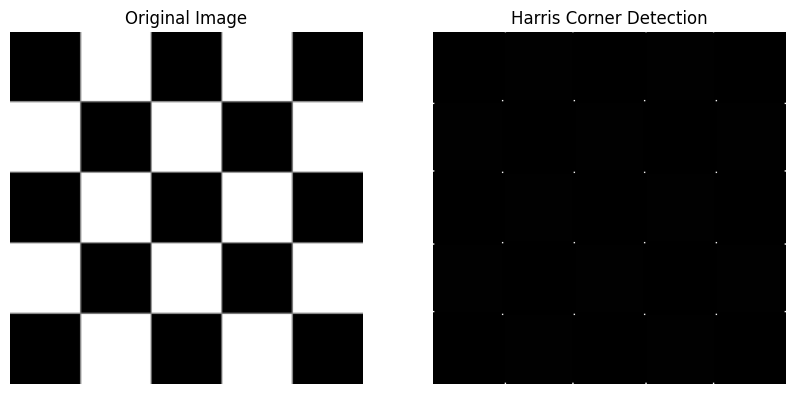

In [60]:
alpha = 0.04
threshold = 0.01

# Compute image gradients
grad_x, grad_y = compute_gradients(image)

# Compute products of gradients
Ixx = grad_x ** 2
Iyy = grad_y ** 2
Ixy = grad_x * grad_y

# Smooth products of gradients with gaussian filter
Ixx = cvF.gaussian_blur(Ixx, 5, 1.5)
Iyy = cvF.gaussian_blur(Iyy, 5, 1.5)
Ixy = cvF.gaussian_blur(Ixy, 5, 1.5)

# Compute cornerness
det_M = Ixx * Iyy - Ixy ** 2
trace_M = Ixx + Iyy
C = det_M - alpha * (trace_M ** 2)

# Threshold on C to filter for high cornerness
corners = C > threshold * C.max()

corners = non_max_suppression(C, corners, 3)

# Mark corners
corner_image = image.cpu().numpy()
corner_image[corners.cpu()] = 255

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Harris Corner Detection")
plt.imshow(corner_image.squeeze(), cmap='gray')
plt.axis("off")

plt.show()

# Histograms of Oriented Gradients
1. Extract a square window (block) of some size
2. Divide block into a square grid of sub-blocks (cells)
3. Compute orientation histogram of each cell
4. Concatenate the histograms together
5. Normalize $v$ (the concatenation of the histograms)
    - Option 1: Divide $v$ by its Euclidean norm
    - Option 2: Divide $v$ by its $L_1$ norm (sum of all absolute values of $v$)
    - Option 3:
        - Divide $v$ by its Euclidean norm
        - Clip any value over 0.2
        - Divide the resulting $v$ by its Euclidean norm

In [61]:
def get_histograms(grad, theta, n_bins=9):
    bins = torch.linspace(0, 180, n_bins + 1, device=device)
    histograms = torch.zeros((32, 32, n_bins), dtype=torch.float, device=device)

    grad_magnitudes = grad.view(1, 1, 32, 8, 32, 8)
    grad_orientations = theta.view(1, 1, 32, 8, 32, 8)

    for i in range(n_bins):
        lower_bound = bins[i]
        upper_bound = bins[i + 1]
        mask = (grad_orientations >= lower_bound) & (grad_orientations < upper_bound)
        masked_magnitudes = grad_magnitudes * mask.float()

        histograms[:, :, i] = masked_magnitudes.sum(dim=[3, 5])

    return histograms

def hog(histograms, cell_len=8, n_bins=9):
    n_cells = histograms.shape[0]
    image_len = n_cells * cell_len

    radius = min(cell_len, cell_len) // 2 - 1
    orientations_arr = torch.arange(n_bins)

    orientation_bin_midpoints = torch.pi * (orientations_arr + 0.5) / n_bins
    dr_arr = radius * torch.sin(orientation_bin_midpoints)
    dc_arr = radius * torch.cos(orientation_bin_midpoints)
    hog_image = torch.zeros((image_len, image_len), dtype=torch.float)

    for r in range(n_cells):
        for c in range(n_cells):
            for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                center = tuple([r * cell_len + cell_len // 2, c * cell_len + cell_len // 2])
                rr, cc = line(
                    int(center[0] - dc),
                    int(center[1] + dr),
                    int(center[0] + dc),
                    int(center[1] - dr),
                )
                hog_image[rr, cc] += histograms[r, c, o]

    return hog_image

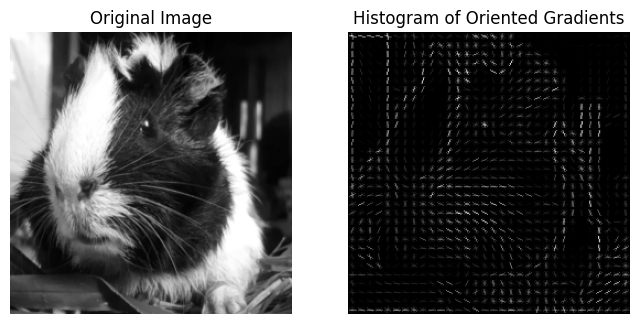

In [62]:
img = cv2.imread("img3.png", cv2.IMREAD_GRAYSCALE)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

image = transform(img).to(device).unsqueeze(0)
img = transforms.ToPILImage()(image.squeeze())

# Compute gradients
grad_x, grad_y = compute_gradients(image)

# Compute gradient magnitude and orientation
grad = torch.sqrt(grad_x ** 2 + grad_y ** 2)
theta = torch.atan2(grad_y, grad_x)

grad = grad / grad.max()

# Normalize theta to range [0, 180)
theta = theta * 180.0 / torch.pi
theta[theta < 0] += 180
theta = torch.remainder(theta, 180.0)

histograms = get_histograms(grad, theta)

hog_image = hog(histograms.cpu().numpy())

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Histogram of Oriented Gradients")
plt.imshow(hog_image, cmap='gray')
plt.axis('off')

plt.show()

# Scale Invariant Feature Transform (SIFT)
Uses image to identify local feature coordinates that is invariant to translation, rotation, or scale

1. Scale-Space Extrema Detection - Search over multiple scales and image locations
    - Finding blobs by approximating LoG with DoG
    - Obtain gaussian pyramid for each layer in an octabe blur with different sigms for DoG
2. Key-Point Localization - Fit a model to determine location and scale, then select key-points based on a measure of stability
3. Orientation Assignment - Compute best orientations for each key-point region
4. Key-Point Description - Use local image gradients at selected scale and rotation to describe each key-point region

Automatic Scale Selection
- Function responses for increasing scale (map different scales to the function results and the highest function result has the best scale)
- Function can be 2nd derivative of Gaussian (Laplacian of Gaussian)

(697, 844)


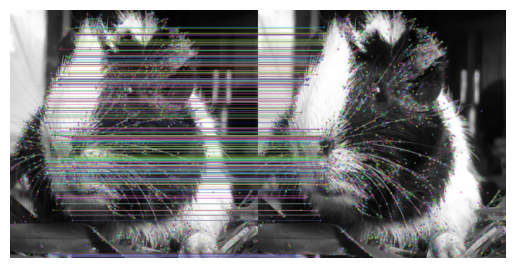

In [63]:
sift = cv2.SIFT.create()
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

img1 = cv2.imread("img3.png", cv2.IMREAD_GRAYSCALE)
print(img1.shape)
img1 = cv2.resize(img1, (1024, 1024))
img2 = cv2.imread("img3.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(img2, (1024, 1024))

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[300:600], img2)

plt.imshow(img3, cmap='gray')
plt.axis('off')
plt.show()

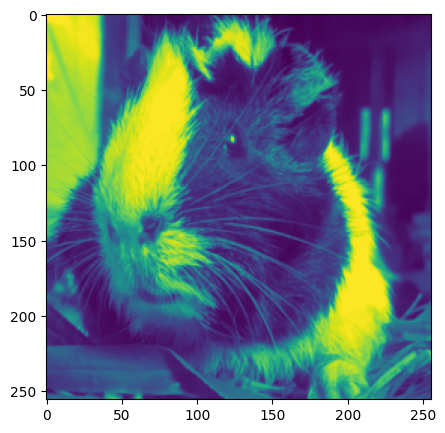

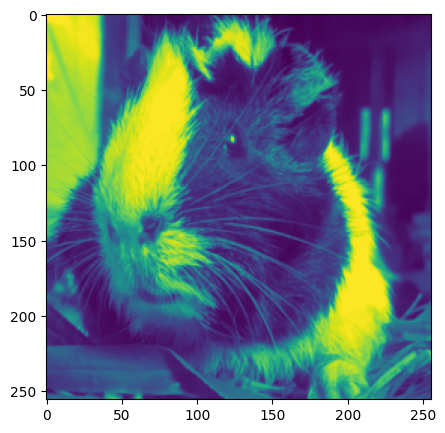

In [69]:
# def scale_space_extrema_detection(image: torch.Tensor, num_octaves=4, num_scales=5, sigma=1.6):
#     octaves = []
#     k = 2 ** (1 / num_scales)

#     for _ in range(num_octaves):
#         octave = [image]
 
#         for scale in range(1, num_scales+3):
#             sigma_scale = sigma * (k ** scale)
#             kernel_size = int(4 * sigma_scale + 1)

#             if (kernel_size % 2 == 0):
#                 kernel_size += 1
            
#             blurred = cvF.gaussian_blur(image, kernel_size=kernel_size, sigma=sigma_scale)
#             octave.append(blurred)

#         octaves.append(octave)
#         image = F.avg_pool2d(image, 2)
    
#     return octaves

def laplacian_of_gaussian(image: torch.Tensor, kernel_size, sigma):
    # Get x and y
    ax = torch.arange(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0, device=device, dtype=torch.float)
    xx, yy = torch.meshgrid(ax, ax, indexing=None)

    # Build gaussian kernel using formula
    gaussian_kernel = torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    gaussian_kernel /= gaussian_kernel.sum()
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)

    log_image = F.conv2d(image, gaussian_kernel, padding=kernel_size//2)

    # Apply laplacian operator to gaussian kernel
    log_kernel = -1 // (torch.pi * sigma ** 4) * (1 - (xx ** 2 + yy ** 2) / (2 * sigma ** 2)) * torch.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    log_kernel -= log_kernel.mean()
    log_kernel = log_kernel.view(1, 1, kernel_size, kernel_size)

    # Convolve image
    log_image = F.conv2d(log_image, log_kernel, padding=kernel_size//2)

def scale_space_extrema_detection(image: torch.Tensor, num_octaves=4, num_scales=5, sigma=1.6):
    octaves = []
    k = 2 ** (1 / num_scales)

    for _ in range(num_octaves):
        octave = []

        for scale in range(1, num_scales+1):
            c_sigma = sigma * (k ** scale)
            c_kernel_size = int(6 * c_sigma + 1)

            if (c_kernel_size % 2 == 0):
                c_kernel_size += 1

            octave.append()

        octaves.append(octave)
        image = F.avg_pool2d(image, 2)

    return octaves

def detect_keypoints(octaves):
    keypoints = []

    for octave in octaves:
        for i in range(1, len(octave)-1):
            prev, curr, next = octave[i-1], octave[i], octave[i+1]

            extrema = (curr > prev) & (curr > next) & \
                (curr > F.pad(curr, (1, 1, 1, 1))[:, 1:-1, 1:-1]) & \
                (curr > F.pad(curr, (1, 1, 1, 1))[:, 1:-1, :-2]) & \
                (curr > F.pad(curr, (1, 1, 1, 1))[:, 1:-1, 2:]) & \
                (curr > F.pad(curr, (1, 1, 1, 1))[:, :-2, 1:-1]) & \
                (curr > F.pad(curr, (1, 1, 1, 1))[:, 2:, 1:-1])
            
            keypoints.append((i, extrema.nonzero()))

    return keypoints

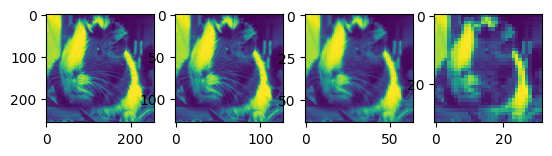

In [65]:

octaves = scale_space_extrema_detection(image)
octaves

In [66]:
keypoints = detect_keypoints(octaves)
keypoints

TypeError: 'NoneType' object is not iterable